# Compatibility with HDSBCAN

A fast multicore version of HDSBCAN is not much use if it can't reproduce the clustering we would have gotten with the classic ``hdbscan`` library. The bad news is that, because it uses a different stack for compiling things (numba instead of cython), combined with floating point precision issues, and slightly different (and vastly more efficient) approches to condensed tree construction an exactly identical clustering cannot be guaranteed. On the other hand we are executing the same underlying algorithm, so aside from potentially permuting the label numbers of cluster and modulo the rare cases where the tree get juggled by precision issues, the results will be essentially the same. And we can measure that! Let's load some libraries and get started.

In [1]:
import numpy as np
import pandas as pd
import sklearn.datasets
import sklearn.metrics

import hdbscan
import fast_hdbscan

import seaborn as sns

sns.set(rc={"figure.figsize":(8, 8)})

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Since the assigned label numbers from ``fast_hdbscan`` and ``hdbscan`` can be different, we need a smarter way to determine if we have produced the same clustering than just checking if the output vectors are identical. Conveniently there are metrics for comparing clusterings. The two relevant ones here are the [Adjusted Rand Score](https://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-score) and the [Adjusted Mutual Information Score](https://scikit-learn.org/stable/modules/clustering.html#mutual-info-score). You can read more about their details in the scikit-learn documentation linked. For our purposes it suffices to note that they measure how similar two clusterings are, with a perfect score of 1.0 if the clusterings are identical, and a score of 0.0 if they are essentially unrelated to each other (as good as random). We can run ``fast_hdbscan`` and ``hdbscan`` on the same randomly generated dataset and compare the ARI and AMI scores. In fact let's make a function to do that a whole bunch of times:

In [2]:
def compare_hdbscan_models(n_runs=100):
    aris = np.zeros(n_runs)
    amis = np.zeros(n_runs)
    for i in range(n_runs):
        data, _ = sklearn.datasets.make_blobs(n_samples=20000, centers=25, cluster_std=0.5)
        classic_hdbscan_labels = hdbscan.HDBSCAN(approx_min_span_tree=False).fit_predict(data.astype(np.float64))
        fast_hdbscan_labels = fast_hdbscan.HDBSCAN().fit_predict(data.astype(np.float64))
        aris[i] = sklearn.metrics.adjusted_rand_score(classic_hdbscan_labels, fast_hdbscan_labels)
        amis[i] = sklearn.metrics.adjusted_mutual_info_score(classic_hdbscan_labels, fast_hdbscan_labels)
    results = pd.DataFrame({"Adjusted Rand Index": aris, "Adjusted Mutual Information": amis})
    return results

Now we can simply plot the distributions of those scores over the 100 different randomly generated datasets. The first thing to note is that the vast majority of the time the scores are 1.0 for a perfect match, or so close to 1.0 that it hardly matters. There are a few outlying cases where the scores are notably lower however. What happened there?

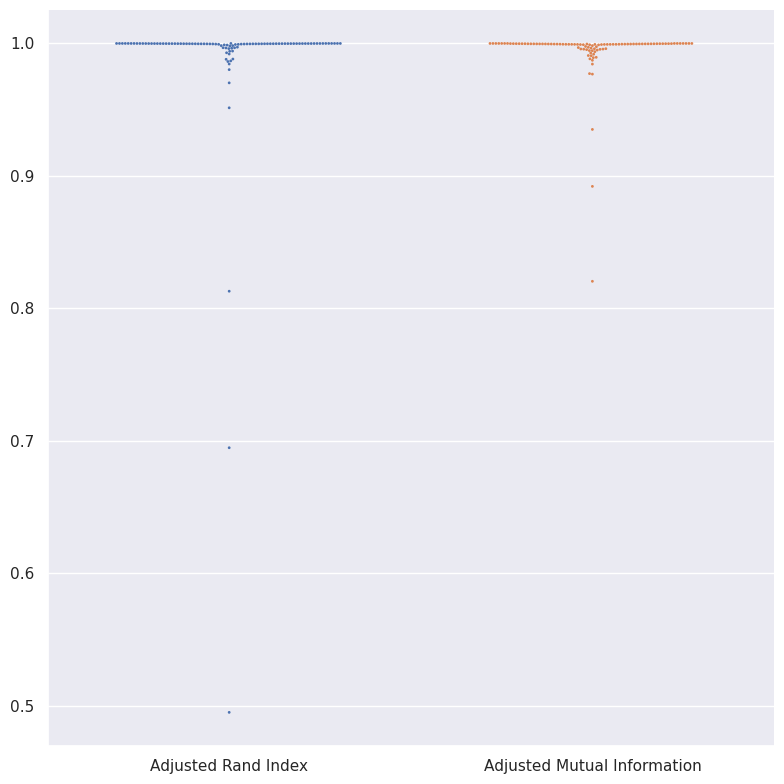

In [3]:
sns.catplot(compare_hdbscan_models(), height=8, kind="swarm", size=2)

It turns out that it is not uncommon for multiple points to have the same mutual reachability distance to a given point. Given such ties they can end up in a slightly different order in the tree. Mix that with floating point precision issues that can also subtley rearrange the order of points in the tree, and the result can be somewhat different condensed trees. So yes, in rare cases it is possible to end up with different clusterings between ``hdbscan`` and ``fast_hdbscan``. It is worth noting, however, that qualitiatively these clustering are, in fact, very similar -- it is usually a matter of mergeing or splitting a single cluster that was right on the cusp, or a change in noise points with respect to a cluster or two.

So, yes results can differ. For practical purposes they are almost always effectively identical; and in the rare cases where that's not the case they are qualitiatively very very similar. So, unless you need to exactly replicate ``hdbscan`` the ``fast_hdbscan`` library should be quite sufficient for your needs.